# Implied Volatility and the Volatility Smile

Real markets do not produce a flat volatility curve. For fixed maturity, implied volatility typically varies with the strike and forms what is known as a smile or smirk.

Even a simple synthetic dataset is enough to illustrate how these shapes arise and why they matter.

## Aims of this project

1. Define the implied volatility problem as a numerical root-finding task.
2. Implement a robust Newton/bisection solver to invert the Black-Scholes formula.
3. Generate a synthetic set of option prices and compute implied volatilities across strikes.
4. Construct and visualise the volatility smile.
5. Discuss basic properties of the smile (monotonicity, curvature, departures from the flat BS model).

The implementation focuses on the numerical aspects of calibration rather than market microstructure.


## Implied volatility as an inversion problem

In the Black-Scholes setting the price of a European call with spot $S_0$, strike $K$, rate $r$, maturity $T$ and volatility $\sigma$ is given by  
$C_{BS}(\sigma) = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)$,  
where the terms $d_1$ and $d_2$ depend on $\sigma$.

For fixed contract parameters this price increases monotonically in $\sigma$.

Markets quote the option price rather than the volatility.  
Given an observed value $C_{mkt}$, the implied volatility is defined as the solution of  
$C_{BS}(\sigma) = C_{mkt}$.

There is no closed-form expression for this inverse.  
The computation reduces to finding a root of  
$f(\sigma) = C_{BS}(\sigma) - C_{mkt}$.

Numerically, a stable method combines Newton’s iteration with a bisection bracket.  
Newton uses the derivative  
$f'(\sigma) = \text{Vega}$  
to accelerate convergence.  
Bisection controls the search region and guarantees that the root remains inside the admissible interval.

This inversion procedure forms the core of volatility calibration: option desks compute implied volatilities across many strikes and maturities to monitor the shape of the volatility surface.


## Numerical structure

The previous equations determine the quantities that the implementation must evaluate.

Given parameters $(S_0, K, r, T)$ the Black-Scholes formula provides the map  
$\sigma \mapsto C_{BS}(\sigma)$,

and the implied volatility problem asks for the value of $\sigma$ such that  
$C_{BS}(\sigma) - C_{mkt} = 0$.

The code therefore requires two components:

1. a function that computes the Black-Scholes call price and its derivative with respect to $\sigma$ (the Vega),
2. a root-finding routine that combines Newton updates with a bisection safeguard.

This mirrors the numerical workflow used in practice: evaluate the pricing function and its sensitivity, then iterate until the price error falls below a specified tolerance.

The following cells implement these components directly.


## Implementation Setup

### Libraries and Parameters


In [8]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

S0 = 100
r = 0.01
T = 1.0


### Black-Scholes Model

The Black-Scholes model describes the evolution of an asset price $(S_t)$ by the stochastic differential equation  
$dS_t = r S_t \, dt + \sigma S_t \, dW_t$,  
where $r$ is the risk-free rate, $\sigma$ is the volatility and $(W_t)$ is Brownian motion.

Under this dynamics the discounted asset price is a martingale, and the value of a European call with strike $K$ and maturity $T$ is given by the Black-Scholes formula  
$C_{BS}(S_0, K, r, T, \sigma) = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)$,

with  
$d_{1,2} = \dfrac{\ln(S_0/K) + (r \pm \tfrac12 \sigma^2)T}{\sigma\sqrt{T}}$.

For fixed contract parameters the price is an increasing function of $\sigma$.  
This monotonicity makes the Black-Scholes formula suitable for inversion: given an observed market price, the implied volatility is the value of $\sigma$ that reproduces it. The numerical work that follows implements this inversion.


In [9]:
def bs_call_price(S0, K, r, sigma, T):
    """
    Black-Scholes price of a European call option.
    """
    if sigma <= 0 or T <= 0:
        # Degenerate cases: no volatility or zero time
        return max(S0 - K * np.exp(-r * T), 0.0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


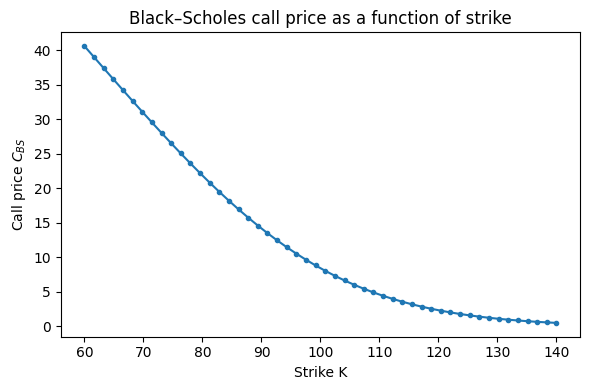

In [ ]:
# demonstration
sigma_test = 0.2
Ks = np.linspace(60, 140, 50)
prices = [bs_call_price(S0, K, r, sigma_test, T) for K in Ks]

plt.figure(figsize=(6,4))
plt.plot(Ks, prices, marker='o', linestyle='-', ms=3)
plt.xlabel("Strike K")
plt.ylabel("Call price $C_{BS}$")
plt.title("Black-Scholes call price as a function of strike")
plt.tight_layout()
plt.savefig("figs/black_scholes_call_price_vs_strike_function.png", dpi=300)
plt.show()


### Vega and the Objective Function

To apply Newton’s method the implementation requires the derivative of the pricing function with respect to $\sigma$. For a European call this quantity is the Vega,

$\text{Vega} = \dfrac{\partial C_{BS}}{\partial \sigma} = S_0 \sqrt{T}\,\varphi(d_1).$

The root-finding algorithm evaluates the function

$f(\sigma) = C_{BS}(\sigma) - C_{mkt},$

and iterates until $f(\sigma)$ becomes sufficiently small.

The following cell implements Vega and the objective function used by the solver.


In [ ]:
def bs_vega(S0, K, r, sigma, T):
    """
    Vega of a European call option under Black-Scholes.
    """
    if sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S0 * np.sqrt(T) * norm.pdf(d1)

def objective_sigma(sigma, S0, K, r, T, C_mkt):
    """
    Objective function f(sigma) = C_BS(sigma) - C_mkt.
    """
    return bs_call_price(S0, K, r, sigma, T) - C_mkt


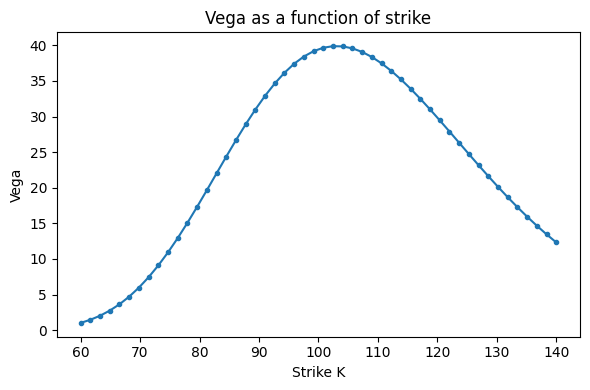

In [12]:
# verification plot
vega_vals = [bs_vega(S0, K, r, sigma_test, T) for K in Ks]

plt.figure(figsize=(6,4))
plt.plot(Ks, vega_vals, marker='o', linestyle='-', ms=3)
plt.xlabel("Strike K")
plt.ylabel("Vega")
plt.title("Vega as a function of strike")
plt.tight_layout()
plt.savefig("figs/vega_as_function_of_strike.png", dpi=300)
plt.show()


### Newton-Bisection Solver

Pure Newton updates can fail when Vega is small or when the initial guess lies far from the true solution. A bisection bracket stabilises the iteration by ensuring that the root remains inside an interval where the function changes sign.


The solver maintains a bracket $[\sigma_{\min}, \sigma_{\max}]$ and updates as follows:

1. Evaluate $f(\sigma)$ and Vega$(\sigma)$.
2. Take a Newton step if the derivative is not too small and the update remains inside the bracket.
3. Otherwise fall back to a bisection step.
4. Update the bracket depending on the sign of $f$.
5. Stop when the absolute price error falls below a given tolerance.

This hybrid method is simple, robust, and sufficient for computing implied volatilities across a grid of strikes.


In [ ]:
def implied_vol_newton_bisection(C_mkt, S0, K, r, T,
                                 sigma_min=0.01, sigma_max=3.0,
                                 tol=1e-8, max_iter=100):
    """
    hybrid Newton-bisection solver for implied volatility.
    """
    f_min = objective_sigma(sigma_min, S0, K, r, T, C_mkt)
    f_max = objective_sigma(sigma_max, S0, K, r, T, C_mkt)

    # ensure the bracket contains a root
    if f_min * f_max > 0:
        return np.nan

    sigma = 0.5 * (sigma_min + sigma_max)

    for _ in range(max_iter):
        f_val = objective_sigma(sigma, S0, K, r, T, C_mkt)
        if abs(f_val) < tol:
            return sigma

        vega = bs_vega(S0, K, r, sigma, T)
        newton_ok = (vega > 1e-8)

        if newton_ok:
            sigma_new = sigma - f_val / vega
            if sigma_min < sigma_new < sigma_max:
                sigma = sigma_new
            else:
                sigma = 0.5 * (sigma_min + sigma_max)
        else:
            sigma = 0.5 * (sigma_min + sigma_max)

        # update bracket
        f_new = objective_sigma(sigma, S0, K, r, T, C_mkt)
        if f_min * f_new <= 0:
            sigma_max = sigma
            f_max = f_new
        else:
            sigma_min = sigma
            f_min = f_new

    return sigma


### Newton-Bisection Convergence Experiment

The implied volatility solver combines Newton updates with a bisection bracket to ensure that the iteration remains stable. Although the algorithm is simple, it is useful to visualise how the method approaches the root of the equation

$f(\sigma) = C_{BS}(\sigma) - C_{mkt} = 0.$

To illustrate this behaviour, we fix a strike $K$ and generate a synthetic market price using a known volatility. The solver is then applied to recover the corresponding implied value. Recording the sequence of iterates $\sigma_0, \sigma_1, \sigma_2, \dots$ provides a direct picture of how the algorithm moves toward the solution. Plotting the absolute pricing error

$|f(\sigma_n)|$

against the iteration index shows the rate at which the method converges.

The following cell constructs such an example and visualises the decay of the error across the iterations.


In [ ]:
# convergence experiment for the Newton-bisection solver

K_test = 100        # at-the-money strike
sigma_true = 0.25   # true volatility used to generate the synthetic price

# synthetic market price
C_mkt_test = bs_call_price(S0, K_test, r, sigma_true, T)

# record the iteration path manually
sigma_min = 0.01
sigma_max = 3.0
sigma = 0.5 * (sigma_min + sigma_max)

iterates = []
errors = []

for _ in range(50):
    f_val = objective_sigma(sigma, S0, K_test, r, T, C_mkt_test)
    iterates.append(sigma)
    errors.append(abs(f_val))

    if abs(f_val) < 1e-12:
        break

    vega = bs_vega(S0, K_test, r, sigma, T)

    # choose Newton step if feasible
    newton_ok = (vega > 1e-8)

    if newton_ok:
        sigma_new = sigma - f_val / vega
        if sigma_min < sigma_new < sigma_max:
            sigma = sigma_new
        else:
            sigma = 0.5 * (sigma_min + sigma_max)
    else:
        sigma = 0.5 * (sigma_min + sigma_max)

    # update bracket
    f_new = objective_sigma(sigma, S0, K_test, r, T, C_mkt_test)

    if objective_sigma(sigma_min, S0, K_test, r, T, C_mkt_test) * f_new <= 0:
        sigma_max = sigma
    else:
        sigma_min = sigma


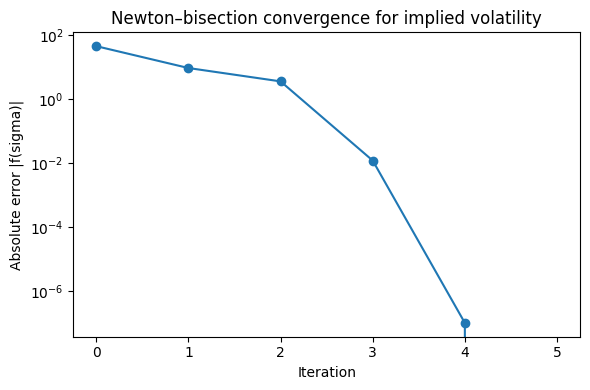

In [ ]:
plt.figure(figsize=(6,4))
plt.semilogy(errors, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Absolute error |f(sigma)|")
plt.title("Newton-bisection convergence for implied volatility")
plt.tight_layout()
plt.savefig("figs/newton_bisection_convergence_for_implied_volatility.png", dpi=300)
plt.show()


### Summary of diagnostics

The preliminary checks confirm that the main components of the inversion procedure behave as expected. The Black-Scholes price decreases smoothly with the strike, the Vega curve peaks near the money and decays in the wings, and the Newton bisection method converges rapidly to the implied volatility for a synthetic market price. These results indicate that the pricing function, its sensitivity, and the numerical solver are all functioning correctly.

We now use the solver across a range of strikes to construct a synthetic volatility smile.


# Constructing a volatility smile

## Synthetic market environment

To construct a volatility smile we keep the model parameters fixed and vary the strike. The solver from the previous section provides implied volatilities once a market price is specified. A synthetic market is obtained by choosing a simple strike-dependent volatility and using it to generate Black-Scholes prices. These prices serve as inputs for the inversion step.

This section defines the synthetic volatility curve, computes the corresponding option prices and recovers the implied volatilities across the strike range.


### Synthetic volatility smile

To see how the inversion behaves across strikes we prescribe a simple strike dependent volatility. The spot, rate and maturity remain fixed as in the previous section, while the volatility varies with the moneyness $K/S_0$. This defines a “true” smile from which synthetic market prices are generated.

For each strike $K$ the market price is taken to be

$C_{mkt}(K) = C_{BS}(S_0, K, r, T, \sigma_{\text{true}}(K)),$

where $\sigma_{\text{true}}(K)$ is a smooth function of $K/S_0$. The implied volatility solver is then applied to $(K, C_{mkt}(K))$ to recover an estimate $\hat{\sigma}_{imp}(K)$.

The first step is to specify $\sigma_{\text{true}}(K)$ and compute the corresponding prices.


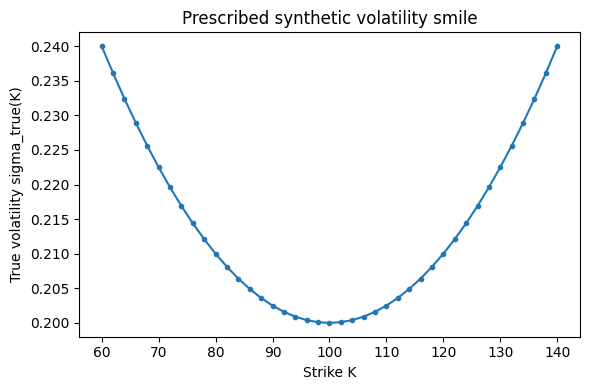

In [16]:
# strike grid for the smile
Ks = np.linspace(60, 140, 41)

def sigma_true(K):
    """
    Synthetic volatility smile as a function of strike.
    Simple convex function of moneyness K/S0.
    """
    m = K / S0
    return 0.2 + 0.25 * (m - 1.0)**2

# true volatilities and corresponding synthetic market prices
sigmas_true = np.array([sigma_true(K) for K in Ks])
C_mkt = np.array([bs_call_price(S0, K, r, sigma_true(K), T) for K in Ks])

# plot the prescribed true smile
plt.figure(figsize=(6,4))
plt.plot(Ks, sigmas_true, marker='o', linestyle='-', ms=3)
plt.xlabel("Strike K")
plt.ylabel("True volatility sigma_true(K)")
plt.title("Prescribed synthetic volatility smile")
plt.tight_layout()
plt.savefig("figs/prescribed_synthetic_volatility_smile.png", dpi=300)
plt.show()


## Implied volatilities across strikes

Given the synthetic prices $C_{mkt}(K)$ and the solver from the previous section, the implied volatility at each strike is obtained by inverting the Black-Scholes formula. For a well-behaved numerical scheme the recovered curve $\hat{\sigma}_{imp}(K)$ should match the prescribed $\sigma_{\text{true}}(K)$ up to the chosen tolerance.

The following cell applies the Newton bisection solver to each strike and compares the recovered implied volatilities with the underlying smile.


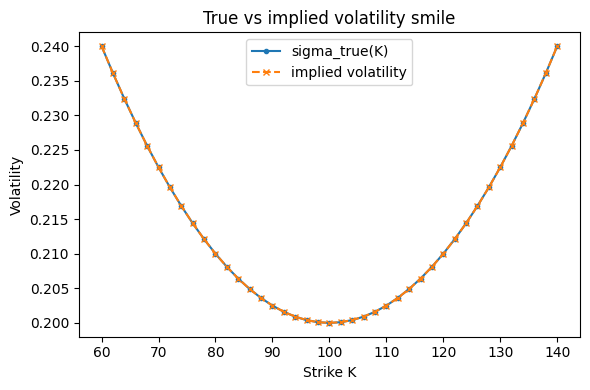

In [17]:
# compute implied volatilities from the synthetic market prices
imp_vols = []

for K, C in zip(Ks, C_mkt):
    sigma_imp = implied_vol_newton_bisection(C, S0, K, r, T)
    imp_vols.append(sigma_imp)

imp_vols = np.array(imp_vols)

# plot true vs implied smile
plt.figure(figsize=(6,4))
plt.plot(Ks, sigmas_true, marker='o', linestyle='-', ms=3, label="sigma_true(K)")
plt.plot(Ks, imp_vols, marker='x', linestyle='--', ms=4, label="implied volatility")

plt.xlabel("Strike K")
plt.ylabel("Volatility")
plt.title("True vs implied volatility smile")
plt.legend()
plt.tight_layout()
plt.savefig("figstrue_vs_implied_volatility_smile.png", dpi=300)
plt.show()


## Discussion

The results above show that the main components required for volatility inversion behave in a stable and predictable way. The Black-Scholes price varies smoothly with the strike and provides the basic forward map needed for calibration. The Vega curve is consistent with the theoretical shape, with a maximum near the money and lower sensitivity in the wings. This behaviour influences the numerical scheme, since Newton updates become more reliable in regions where Vega is not too small.

The convergence experiment indicates that the hybrid method is effective. The initial steps reflect the bracketing behaviour, followed by rapid convergence once the iterates move into a region where Newton’s method is accurate. The error decreases to numerical precision in only a few iterations, confirming that the solver is adequate for computing implied volatilities across a strike range.

The synthetic market constructed in the second part shows the behaviour of a simple volatility smile. The prescribed function sigma_true(K) decreases towards the money and increases for deep in-the-money and out-of-the-money strikes. The implied volatilities recovered by inversion match this shape closely across the full grid, with only small numerical deviations. The agreement between the true and implied curves confirms that the inversion routine behaves consistently across different regions of the smile.

Although the Black-Scholes model assumes constant volatility, the smile illustrates how option prices encode strike dependence in practice. Even this simple synthetic example shows the characteristic curvature and symmetry observed in more realistic settings. The numerical findings here form the basic structure used in calibration tasks, where implied volatilities are computed repeatedly to monitor the shape of the volatility surface.


## Conclusion

This notebook developed a complete numerical procedure for computing implied volatilities and illustrated how volatility smiles arise from strike dependent pricing behaviour. The analysis began with the Black-Scholes model and examined the basic quantities required for inversion, including the pricing function and its sensitivity with respect to volatility. Diagnostic plots confirmed that these components behave as expected and that the numerical environment is stable.

A hybrid Newton bisection method was implemented to invert the pricing map. Tests showed that the solver converges reliably and reaches the desired accuracy within a small number of iterations. This provides a practical tool for computing implied volatilities across a grid of strikes.

A synthetic market was then constructed by prescribing a simple volatility smile. The inversion routine recovered the smile with high accuracy, demonstrating how the numerical scheme interacts with the geometry of the problem. The results show that even in a basic setting, implied volatility captures structure that is not visible from the Black-Scholes formula alone.

The notebook therefore provides a compact example of how calibration problems are approached numerically. The same principles extend to more advanced models and larger volatility surfaces, where stability, monotonicity and convergence remain central considerations.
